In [26]:
import os
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
import pickle
import sys
sys.path.insert(0,'..')
from xbrl.algs.nnmodel import MLLinearNetwork
from xbrl.envs import hlsutils

%matplotlib inline

def flatten_dict(d):
    out = {}
    for key, val in d.items():
        if isinstance(val, dict):
            val = [val]
        if isinstance(val, list):
            for subdict in val:
                deeper = flatten_dict(subdict).items()
                out.update({key + '.' + key2: val2 for key2, val2 in deeper})
        else:
            out[key] = val
    return out

# EPS_GREEDY
prefix = "/private/home/pirotta/lrcb/wheel_0524/"
folders = [
    # f"{prefix}nnegreedy_mse",
    # f"{prefix}nnegreedy_minfeat",
    f"{prefix}nnegreedy_rayleigh",
]

df = None
result_keys = []
fcnt = 0
for rootdir in folders:
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            if os.path.exists(os.path.join(d, "latest_result.pkl")):
                fcnt+=1
                with open(os.path.join(d, "config.json"), "r") as jf:
                    config = json.load(jf)
                    config = flatten_dict(config)
                with open(os.path.join(d, "latest_result.pkl"), "rb") as jf:
                    results = pickle.load(jf)
                if config['layers'] == "100,100,50,20,10" and config["glrt_scale"] == 3 and config['epsilon_decay'] == "sqrt":
                    print(d, results['expected_regret'][-1])
                # rank = config['newrank']
                # algo = config['algo']
                # layers = config['layers']
                # name = f"{algo}_{rank}_{layers}"
                for k in results.keys():
                    config[k] = [results[k]]
                
                result_keys = np.unique(result_keys + list(results.keys())).tolist()
                # else:
                #     assert np.all([el in result_keys for el in results.keys()])
                tdf = pd.DataFrame.from_dict(config)
                if df is None:
                    df = tdf
                else:
                    df = pd.concat((df,tdf))
            else:
                print(f"{d} not finished")



assert df.shape[0] == fcnt
print(f"result_keys:\n {result_keys}")
print(f"df.columns.to_list():\n {df.columns.to_list()}")

/private/home/pirotta/lrcb/wheel_0524/nnegreedy_rayleigh/.slurm not finished
/private/home/pirotta/lrcb/wheel_0524/nnegreedy_rayleigh/9 1097.0000000000591
/private/home/pirotta/lrcb/wheel_0524/nnegreedy_rayleigh/1 9238.199999997696
/private/home/pirotta/lrcb/wheel_0524/nnegreedy_rayleigh/3 not finished
/private/home/pirotta/lrcb/wheel_0524/nnegreedy_rayleigh/7 1957.0000000002885
/private/home/pirotta/lrcb/wheel_0524/nnegreedy_rayleigh/5 1784.2000000002324
result_keys:
 ['action', 'best_action', 'best_reward', 'expected_regret', 'expected_reward', 'hls_lambda', 'hls_rank', 'instant_reward', 'max_err', 'mean_abs_err', 'min_feat', 'optimal_arm', 'rank_phi', 'regret', 'runtime', 'train_loss']
df.columns.to_list():
 ['adaptive_bonus_linucb', 'algo', 'batch_size', 'bonus_scale', 'buffer_capacity', 'check_glrt', 'delta', 'device', 'domain.contextgeneration', 'domain.dim', 'domain.feature_expansion', 'domain.mu_1', 'domain.mu_2', 'domain.mu_3', 'domain.narms', 'domain.ncontexts', 'domain.newra

(4, 73)


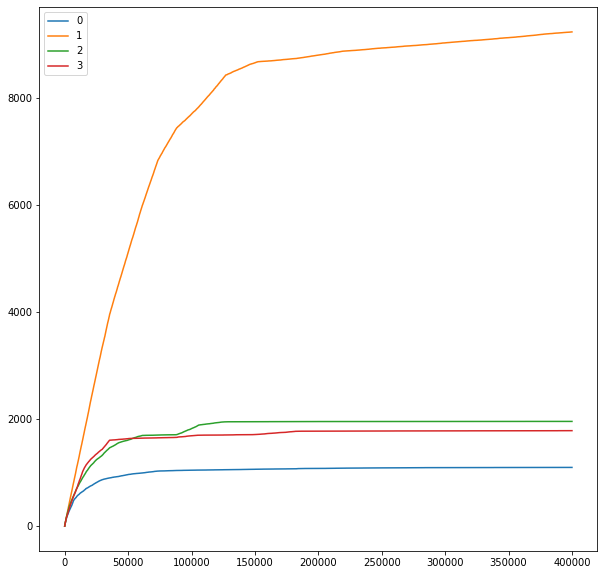

In [27]:
yy = df[(df.layers == "100,100,50,20,10") & (df.glrt_scale == 3) & (df.epsilon_decay == "sqrt")]
print(yy.shape)

plt.figure(figsize=(10,10))
for i in range(yy.shape[0]):
#     print(el)
    plt.plot(yy.iloc[i].expected_regret, label=i)
plt.legend()

In [28]:
import torch
import torch.nn as nn
# fn = "/private/home/pirotta/lrcb/wheel_0524/nnegreedy_minfeat/1/model_state_dict_n379020.pt"
# fn_a = "/private/home/pirotta/lrcb/wheel_0524/nnegreedy_minfeat/1/algo.pt"

# fn = "/private/home/pirotta/lrcb/wheel_0524/nnegreedy_mse/1/model_state_dict_n379020.pt"
# fn_a = "/private/home/pirotta/lrcb/wheel_0524/nnegreedy_mse/1/algo.pt"

fn = "/private/home/pirotta/lrcb/wheel_0524/nnegreedy_rayleigh/1/model_state_dict_n379020.pt"
fn_a = "/private/home/pirotta/lrcb/wheel_0524/nnegreedy_rayleigh/1/algo.pt"

model = MLLinearNetwork(7, [(100, nn.ReLU()),(100, nn.ReLU()),(50, nn.ReLU()),(20, nn.ReLU()),(10, nn.ReLU())]).to(torch.float64)
model.load_state_dict(torch.load(fn))
model.eval()


payload = torch.load(fn_a)
feature_matrix = payload["features"]
rewards = payload["rewards"]
nc,na,dim = feature_matrix.shape

all_features = feature_matrix.reshape(-1, dim)
features_tensor = torch.tensor(all_features, dtype=torch.float64)
phi = model.embedding(features_tensor)

new_phi = phi.detach().numpy().reshape(nc, na, model.embedding_dim)
hls_rank = hlsutils.hls_rank(new_phi, rewards, tol=1e-4)
ishls = 1 if hlsutils.is_hls(new_phi, rewards, tol=1e-4) else 0
hls_lambda = hlsutils.hls_lambda(new_phi, rewards)
rank_phi = hlsutils.rank(new_phi, tol=1e-4)

print(f"hls_rank: {hls_rank}")
print(f"hls_lambda: {hls_lambda}")
print(f"rank_phi: {rank_phi}")

hls_rank: 6
hls_lambda: 0.0
rank_phi: 7


/private/home/pirotta/.conda/envs/xb.simple/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/private/home/pirotta/.conda/envs/xb.simple/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(500, 2)


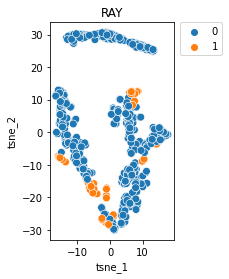

In [29]:
from sklearn.manifold import TSNE, SpectralEmbedding, MDS, Isomap
import seaborn as sns

# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components=n_components)
tsne_result = tsne.fit_transform(phi.detach().numpy())
print(tsne_result.shape)

opt_phi = (rewards.reshape(-1,1) > 1.15).astype(int).squeeze()

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': opt_phi})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=60)
# lim = (tsne_result.min()-5, tsne_result.max()+5)
# ax.set_xlim(lim)
# ax.set_ylim(lim)
ax.set_title("RAY")
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [75]:
phi.detach().numpy()[rewards.reshape(-1) < 1.15]

array([[2.39860758, 0.01308804, 0.        , ..., 0.        , 6.2059968 ,
        0.        ],
       [1.96725875, 0.        , 0.        , ..., 0.        , 5.5096336 ,
        0.        ],
       [2.32082063, 0.        , 0.        , ..., 0.        , 6.09462956,
        0.        ],
       ...,
       [2.15648183, 0.        , 0.        , ..., 0.        , 5.65329942,
        0.        ],
       [1.93669126, 0.        , 0.        , ..., 0.        , 5.40968582,
        0.        ],
       [2.03577434, 0.        , 0.        , ..., 0.        , 5.58801703,
        0.        ]])